In [239]:
from pathlib import Path
import os
from joblib import Memory
from sklearn.datasets import load_svmlight_file
from scipy.sparse import csc_matrix
from scipy.special import expit
from scipy import sparse
from sklearn.preprocessing import normalize
from copy import copy
from sklearn import svm
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder

import pyarrow.feather as feather
import matplotlib.pyplot as plt
import plotnine as p9
import pandas as pd
import numpy as np

def scale_this(xtrain, xtest, xvalid, type = "normalize"):
    for name in xtrain.columns.values:
        if xtrain[name].max() > xtrain[name].min():
            if type == "normalize": # Rescales to mean 0, standard deviation of 1
               xtrain[name] = (xtrain[name] - xtrain[name].mean()) / xtrain[name].std()
               xtest[name] = (xtest[name] - xtest[name].mean()) / xtest[name].std()
               xvalid[name] = (xvalid[name] - xvalid[name].mean()) / xvalid[name].std()
            if type == "standardize": # Rescales to min 0, max 1
                xtrain[name] = (xtrain[name] - xtrain[name].min()) / (xtrain[name].max() - xtrain[name].min())
                xtest[name] = (xtest[name] - xtest[name].min()) / (xtest[name].max() - xtest[name].min())
                xvalid[name] = (xvalid[name] - xvalid[name].min()) / (xvalid[name].max() - xvalid[name].min())
        else: # set values of constant columns to 0
            xtest[name] = 0
            xtrain[name] = 0
            xvalid[name] = 0

In [284]:
idcsc = "C:/Code/GITHUB/csc/Classification-of-Pell-Institutions/data/datasubsets/csc_variable_subsets/id_csc.feather"
cipcsc = "C:/Code/GITHUB/csc/Classification-of-Pell-Institutions/data/datasubsets/csc_variable_subsets/cip_csc.feather"
geoloccsc = "C:/Code/GITHUB/csc/Classification-of-Pell-Institutions/data/datasubsets/csc_variable_subsets/geolocation_csc.feather"
instdemocsc = "C:/Code/GITHUB/csc/Classification-of-Pell-Institutions/data/datasubsets/csc_variable_subsets/inst_demographic_csc.feather"
studdemocsc = "C:/Code/GITHUB/csc/Classification-of-Pell-Institutions/data/datasubsets/csc_variable_subsets/stud_demographic_csc.feather"
pcipcsc = "C:/Code/GITHUB/csc/Classification-of-Pell-Institutions/data/datasubsets/csc_variable_subsets/pcip_csc.feather"
numcsc = "C:/Code/GITHUB/csc/Classification-of-Pell-Institutions/data/datasubsets/csc_variable_subsets/num_csc.feather"

full_df_path = "data/datasubsets/csc_variable_subsets/full_csc_frame.csv"

id_csc = feather.read_feather(idcsc)
cip_csc = feather.read_feather(cipcsc)
geolocation_csc = feather.read_feather(geoloccsc)
inst_demographic_csc = feather.read_feather(instdemocsc)
stud_demographic_csc = feather.read_feather(studdemocsc)
pcip_csc = feather.read_feather(pcipcsc)
num_csc = feather.read_feather(numcsc)

id_csc
cip_csc
geolocation_csc
inst_demographic_csc
stud_demographic_csc
pcip_csc
num_csc

missing = pd.DataFrame(stud_demographic_csc.isna().sum())
missing.reset_index(inplace=True)
missing[missing[0] > 0]

,index,0
2,HSI,4
3,HBCU,4
4,ANNHI,4
5,PBI,4
6,TRIBAL,4
8,NANTI,4
10,AANAPII,4


0       1.0
1       0.0
2       1.0
3       0.0
4       1.0
       ... 
5874    0.0
5875    1.0
5876    1.0
5877    1.0
5878    1.0
Name: PELLCAT, Length: 5879, dtype: float64

In [268]:
id_csc
geolocation_csc
inst_demographic_csc
stud_demographic_csc
num_csc
tar_csc

full_df

cip_csc.head(3)

,UNITID,INSTNM,CIP01ASSOC,CIP01BACHL,CIP01CERT1,CIP01CERT2,CIP01CERT4,CIP03ASSOC,CIP03BACHL,CIP03CERT1,...,CIP52BACHL,CIP52CERT1,CIP52CERT2,CIP52CERT4,CIP54ASSOC,CIP54BACHL,CIP54CERT1,CIP54CERT2,CIP54CERT4,ids
0,100654.0,Alabama A & M University,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,100663.0,University of Alabama at Birmingham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1
2,100690.0,Amridge University,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


SUM of first 37 components 0.802752181128468


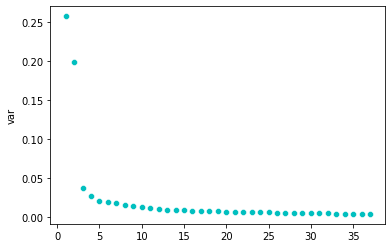

In [286]:
from sklearn.decomposition import PCA
import seaborn as sns
%matplotlib inline

# cip_csc["ids"] = np.array(range(len(cip_csc)))
colums = ['cipPC01','cipPC02','cipPC03','cipPC04','cipPC05','cipPC06','cipPC07','cipPC08','cipPC09','cipPC10','cipPC11','cipPC12',"cipPC13","cipPC14","cipPC15","cipPC16","cipPC17","cipPC18","cipPC19","cipPC20","cipPC21","cipPC22","cipPC23","cipPC24","cipPC25","cipPC26","cipPC27","cipPC28","cipPC29","cipPC30","cipPC31","cipPC32","cipPC33","cipPC34","cipPC35","cipPC36","cipPC37"]

pca = PCA(n_components = 37)
pc = pca.fit_transform(cip_csc.drop(["ids", "UNITID", "INSTNM"], axis = 1)) 
pca_cip = pd.DataFrame(data=pc, columns=colums) 

df = pd.DataFrame({'var':pca.explained_variance_ratio_})
comp = pca.fit_transform(cip_csc.drop(["ids", "UNITID", "INSTNM"], axis = 1)) 
pca_cip = pd.DataFrame(comp, columns=colums)

sns.scatterplot(x=range(1, pca_cip.shape[1]+1), y="var", data=df, color="c");
print("SUM of first 37 components", pca.explained_variance_ratio_[0:37].sum())

pca_cip["ids"] = np.array(range(len(pca_cip)))

full_PCA = pd.merge(cip_csc[["ids", "UNITID", "INSTNM"]], pca_cip, how = "left",
         left_on="ids", right_on="ids")
# pcip_csc["ids"] = np.array(range(len(pcip_csc)))
colums = ['pcipPC01','pcipPC02','pcipPC03','pcipPC04','pcipPC05','pcipPC06']

pca = PCA(n_components = 6)
pc = pca.fit_transform(pcip_csc.drop(["ids", "UNITID", "INSTNM"], axis = 1)) 
pca_pcip = pd.DataFrame(data=pc, columns=colums) # 

df = pd.DataFrame({'var':pca.explained_variance_ratio_})
comp = pca.fit_transform(pcip_csc.drop(["ids", "UNITID", "INSTNM"], axis = 1)) 
pca_pcip = pd.DataFrame(comp, columns=colums) # , columns=colums

sns.scatterplot(x=range(1, pca_pcip.shape[1]+1), y="var", data=df, color="c");
print("SUM of first 6 components", pca.explained_variance_ratio_[0:6].sum())

pca_pcip["ids"] = np.array(range(len(pca_pcip)))

full_PCA = pd.merge(full_PCA, pca_pcip, how = "left",
         left_on="ids", right_on="ids")
# geolocation_csc["ids"] = np.array(range(len(geolocation_csc)))
colums = ['geoPC01','geoPC02','geoPC03','geoPC04','geoPC05','geoPC06']

pca = PCA(n_components = 6)
pc = pca.fit_transform(geolocation_csc.drop(["ids", "UNITID", "INSTNM", "LATITUDE", "LONGITUDE", "CITY", "STABBR", "ZIP"], axis = 1)) 
pca_geo = pd.DataFrame(data=pc, columns=colums) # 

df = pd.DataFrame({'var':pca.explained_variance_ratio_})
comp = pca.fit_transform(geolocation_csc.drop(["ids", "UNITID", "INSTNM", "LATITUDE", "LONGITUDE", "CITY", "STABBR", "ZIP"], axis = 1)) 
pca_geo = pd.DataFrame(comp, columns=colums) # , columns=colums

sns.scatterplot(x=range(1, pca_geo.shape[1]+1), y="var", data=df, color="c");
print("SUM of first 6 components", pca.explained_variance_ratio_[0:2].sum())

pca_geo["ids"] = np.array(range(len(pca_geo)))

geolocation_csc = geolocation_csc[["ids", "UNITID", "INSTNM", "LATITUDE", "LONGITUDE", "CITY", "STABBR", "ZIP"]]
full_PCA = pd.merge(full_PCA, pca_geo, how = "left",
         left_on="ids", right_on="ids")
         
# full_PCA

SUM of first 6 components 0.8632615414379621


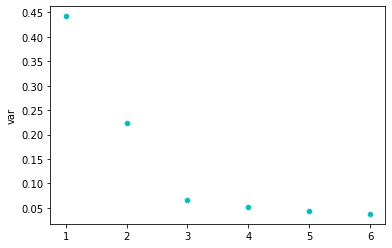

In [287]:
num_csc



# full_PCA

SUM of first 6 components 0.7873565964641012


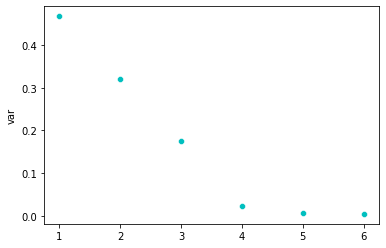

In [288]:



# full_PCA

In [289]:
full_PCA

,ids,UNITID,INSTNM,cipPC01,cipPC02,cipPC03,cipPC04,cipPC05,cipPC06,cipPC07,...,pcipPC03,pcipPC04,pcipPC05,pcipPC06,geoPC01,geoPC02,geoPC03,geoPC04,geoPC05,geoPC06
0,0,100654.0,Alabama A & M University,-2.701575,1.057589,-0.141042,-0.017397,0.172698,-0.099626,0.298292,...,-0.049087,-0.072705,-0.016438,0.003998,-26.445384,16.708134,-5.513608,-4.512352,0.081272,2.133649
1,1,100663.0,University of Alabama at Birmingham,-2.962731,1.928060,0.078580,-0.560827,-0.576495,0.157420,0.664458,...,-0.046612,-0.093924,-0.043612,-0.013851,-26.689969,14.278163,-5.590735,-6.467762,0.276911,3.214189
2,2,100690.0,Amridge University,0.196815,0.822488,2.078724,1.191120,1.167111,-1.917570,-1.385247,...,0.083708,-0.164123,-0.242601,0.017266,-26.831559,12.966686,-5.540667,4.322116,-0.396757,1.375115
3,3,100706.0,University of Alabama in Huntsville,-2.924711,1.244764,-0.613540,0.012379,-0.363798,0.302301,0.203399,...,-0.044003,-0.135857,-0.035968,-0.001986,-26.446430,16.395553,-5.515419,-6.605924,-0.553727,-3.168806
4,4,100724.0,Alabama State University,-2.929884,1.229714,-0.216263,-0.004764,-0.014104,0.040270,0.292585,...,-0.022769,-0.096393,0.021896,-0.021718,-26.366553,17.512760,-5.490307,-3.933037,0.080726,2.234710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5874,5874,493080.0,Institute of Culinary Education,-0.044802,-1.683515,-0.057436,0.171463,0.327808,-0.010893,0.054386,...,0.021056,-0.016924,0.078534,0.026957,-24.346001,-11.433910,-6.619824,0.298119,2.426680,-0.650707
5875,5875,493150.0,Gould's Academy,0.040985,-1.744089,-0.222497,0.126890,0.641959,-0.204883,0.477793,...,-0.002543,0.001123,-0.009847,-0.004220,17.116560,-15.697734,-1.035132,0.276855,0.909909,-0.219402
5876,5876,493372.0,Toni & Guy Hairdressing Academy-Rio Rancho,-0.031153,-1.705675,-0.064656,0.171152,0.268566,-0.092531,0.184268,...,-0.002543,0.001123,-0.009847,-0.004220,5.188707,-14.536340,-0.048267,0.271971,1.529834,-0.358162
5877,5877,493424.0,Career Quest Learning Center-Bay City Branch,0.200003,-1.459797,0.155955,-0.391093,-0.467416,0.570815,-0.440584,...,0.033055,-0.001895,-0.000134,-0.026937,-3.472951,-13.707151,2.751339,0.113886,-1.674373,0.039848
